In [1]:
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [2]:
def KS_plot(dat, col, idx=False):
    if idx:
        sns.distplot(dat[dat['target']==0].iloc[:, col], hist=False, color='green', label='Good')
        sns.distplot(dat[dat['target']==1].iloc[:, col], hist=False, color='red', label='Bad')
    else:
        sns.distplot(dat[dat['target']==0][col], hist=False, color='green', label='Good')
        sns.distplot(dat[dat['target']==1][col], hist=False, color='red', label='Bad')
    plt.legend()
    plt.show()

In [3]:
dat = pd.read_csv('../data/card_transactions_features.csv')

## Z scale feature columns

In [4]:
features_z = dat.iloc[:, 9:]

cols = features_z.columns

In [5]:
features_z = pd.DataFrame(list(features_z.iloc[:, 1:].apply(stats.zscore, axis=1)), columns=cols[1:])

features_z.insert(0, 'target', dat['Fraud'].values)

### Split into OOT and modeling

In [6]:
model_dat = dat[(dat['Date']>'2010-01-15')&(dat['Date']<'2010-11-01')].index
oot = dat[(dat['Date']>='2010-11-01')].index

In [53]:
model_z = features_z.loc[model_dat, :]

In [54]:
rand = []
for x in range(len(model_z)):
    rand.append(random.randint(0, 10))
model_z['rand'] = rand

## KS Score and KS P-Value for feature columns

In [56]:
ks_df = pd.DataFrame()

for col in model_z.columns:
    x = model_z[model_z['target']==0][col].values
    y = model_z[model_z['target']==1][col].values
    ks_df.loc['ks_score', col] = stats.ks_2samp(x, y)[0]
    ks_df.loc['ks_pval', col] = stats.ks_2samp(x, y)[1]

Mean KS score is 0.3388088560376055


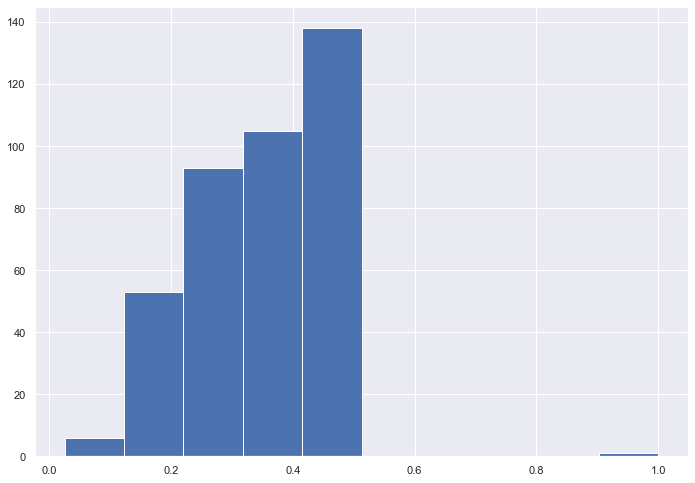

In [57]:
ks_df_keep = ks_df.T

print('Mean KS score is {}'.format(ks_df_keep['ks_score'].mean()))
ks_df_keep['ks_score'].hist()
plt.show()

Mean KS P-Value is 0.0015738666149323628


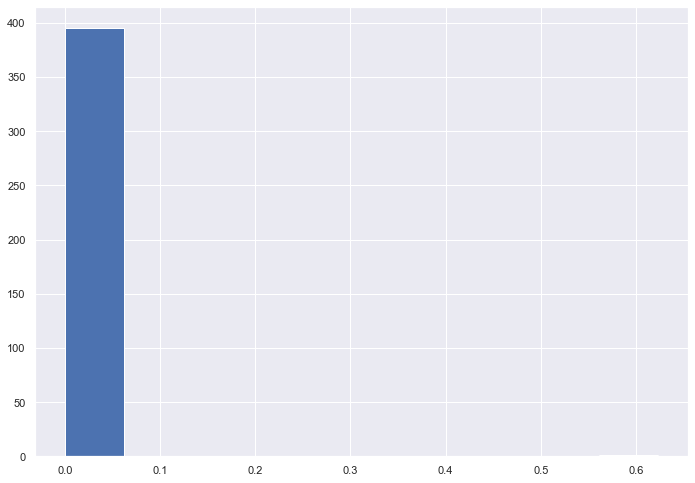

In [58]:
print('Mean KS P-Value is {}'.format(ks_df_keep['ks_pval'].mean()))
ks_df_keep['ks_pval'].hist()
plt.show()

In [59]:
topRows = int(round(len(model_z)*0.03))
j = 0
for col in model_z.columns:
    temp = model_z.sort_values(col, ascending=False)
    temp1 = temp.head(topRows)
    temp2 = temp.tail(topRows)
    needed1 = temp1.loc[:, 'target']
    needed2 = temp2.loc[:, 'target']
    FDR1 = sum(needed1)/model_z['target'].sum()
    FDR2 = sum(needed2)/model_z['target'].sum()
    FDRate = np.maximum(FDR1, FDR2)
    ks_df.loc['FDR', col] = FDRate
    j += 1

In [60]:
ks_df_keep = ks_df.T
ks_df_keep['rank_ks'] = ks_df_keep['ks_score'].rank(ascending=True)
ks_df_keep['rank_FDR'] = ks_df_keep['FDR'].rank(ascending=True)
ks_df_keep['average_rank'] = (ks_df_keep['rank_ks'] + ks_df_keep['rank_FDR']) / 2
ks_df_keep.sort_values('average_rank', ascending=False, inplace=True)

Average rank is 198.5


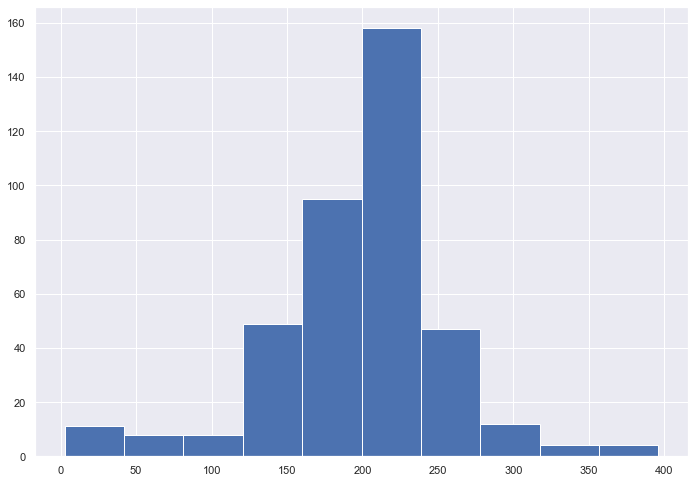

In [61]:
print('Average rank is {}'.format(ks_df_keep['average_rank'].mean()))

ks_df_keep['average_rank'].hist()

## Save KS and FDR df

In [62]:
ks_df_keep.to_csv('../data/card_ks_fdr.csv')

## Recursive Feature Elimination

In [63]:
ks_df_keep = pd.read_csv('../data/card_ks_fdr.csv').rename(columns={'Unnamed: 0': 'column'}).set_index('column')

In [64]:
ks_df_keep

,ks_score,ks_pval,FDR,rank_ks,rank_FDR,average_rank
column,,,,,,
target,1.000000,0.000000e+00,1.000000,396.0,396.0,396.00
total_Cardnum_Merchnum_amount_over_14days,0.432189,1.422773e-139,0.386390,386.0,395.0,390.50
total_Cardnum_Merch zip_amount_over_14days,0.424384,1.358886e-134,0.373702,384.0,393.0,388.50
avg_Cardnum_amount_over_30days,0.450225,1.980550e-151,0.204152,388.0,328.0,358.00
max_Cardnum_amount_over_30days,0.511229,4.007523e-195,0.089965,395.0,304.0,349.50
...,...,...,...,...,...,...
trans_amount_minus_last_with_Cardnum_Merch zip,0.159865,1.829358e-19,0.005767,27.0,8.0,17.50
trans_amount_minus_last_with_Cardnum_Merch state,0.123024,1.062128e-11,0.005767,6.0,8.0,7.00
trans_amount_minus_last_with_Merchnum,0.105812,9.128848e-09,0.006920,2.0,11.0,6.50


In [65]:
filt = list(ks_df_keep.iloc[:80, ].index)

In [66]:
model_z = features_z.loc[model_dat, filt]

In [67]:
model = LogisticRegression(max_iter=1000)

rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=-1,
              scoring='roc_auc')
rfecv.fit(model_z.iloc[:, 1:], model_z.iloc[:, 0])

RFECV(cv=2, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
      scoring='roc_auc')

In [68]:
var_keep = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), model_z.iloc[:, 1:].columns)),
                        columns=['ranking', 'variable'])

In [69]:
pd.set_option('display.max_rows', 80)
var_keep

,ranking,variable
0,1,actual_median_Cardnum_Merch zip_amount_over_3days
1,1,actual_median_Cardnum_Merch zip_amount_over_7days
2,1,actual_norm_Cardnum_Merch state_amount_over_14...
3,1,actual_norm_Cardnum_Merch state_amount_over_3days
4,1,actual_norm_Cardnum_Merch state_amount_over_7days
5,1,actual_norm_Cardnum_amount_over_0days
6,1,actual_norm_Cardnum_amount_over_1days
7,1,actual_norm_Cardnum_amount_over_3days
8,1,actual_total_Cardnum_Merch zip_amount_over_14days
9,1,actual_total_Cardnum_Merch zip_amount_over_30days


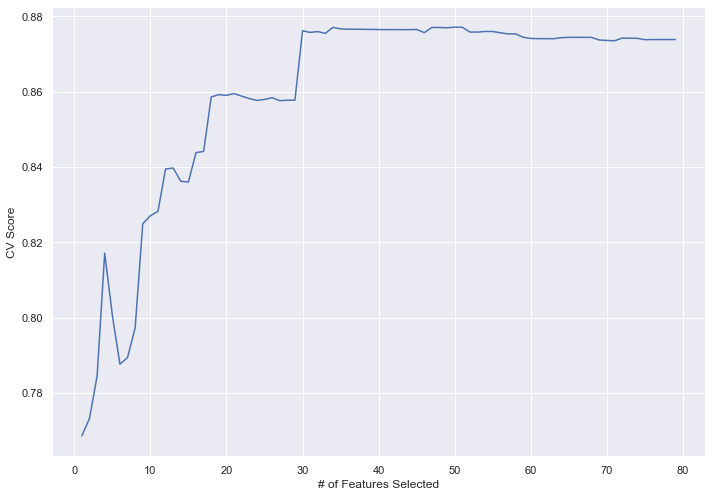

In [70]:
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel('# of Features Selected')
plt.ylabel('CV Score')
plt.show()

In [71]:
filt1 = list(var_keep[var_keep['ranking']==1]['variable'].values)
filt1.insert(0, 'target')

In [72]:
features_rfe2 = model_z.loc[:, filt1]

In [73]:
model2 = LogisticRegression(max_iter=5000)

rfecv2 = RFECV(estimator=model2, step=1, cv=2, verbose=0, n_jobs=-1,
               scoring='roc_auc')
rfecv2.fit(features_rfe2.iloc[:, 1:], features_rfe2.iloc[:, 0])

RFECV(cv=2, estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
      scoring='roc_auc')

In [74]:
var_keep2 = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv2.ranking_), features_rfe2.iloc[:, 1:].columns)),
                         columns=['ranking', 'variable'])

In [75]:
pd.set_option('display.max_rows', 80)
var_keep2

,ranking,variable
0,1,actual_norm_Cardnum_Merch state_amount_over_14...
1,1,actual_norm_Cardnum_Merch state_amount_over_7days
2,1,actual_norm_Cardnum_amount_over_0days
3,1,actual_norm_Cardnum_amount_over_1days
4,1,actual_norm_Cardnum_amount_over_3days
5,1,actual_total_Cardnum_Merch zip_amount_over_14days
6,1,actual_total_Cardnum_Merch zip_amount_over_30days
7,1,actual_total_Cardnum_Merchnum_amount_over_14days
8,1,actual_total_Cardnum_Merchnum_amount_over_30days
9,1,avg_Cardnum_amount_over_30days


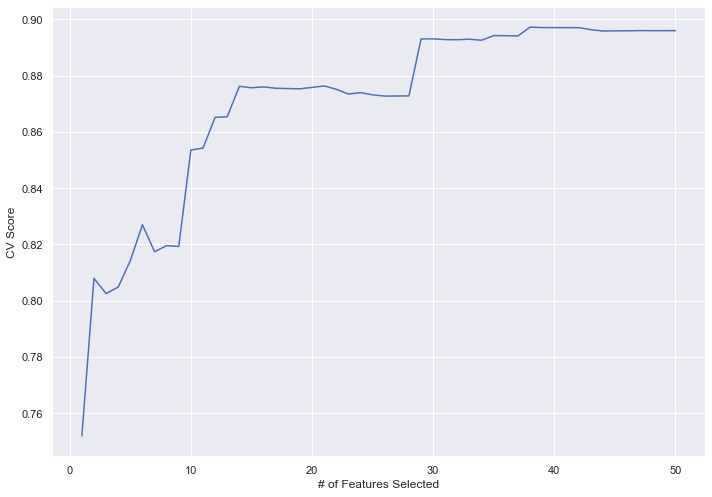

In [76]:
plt.plot(range(1, len(rfecv2.grid_scores_)+1), rfecv2.grid_scores_)
plt.xlabel('# of Features Selected')
plt.ylabel('CV Score')
plt.show()

In [77]:
final_keep = var_keep2[var_keep2['ranking']==1]['variable'].values

In [15]:
final_keep = list(final_keep)
final_keep.insert(0, 'target')

In [16]:
features_z.loc[model_dat, final_keep].to_csv('../data/train.csv', index=False)
features_z.loc[oot, final_keep].to_csv('../data/oot.csv', index=False)
pd.DataFrame(final_keep, columns=['column']).to_csv('../data/final_vars.csv', index=False)